#Install Required Packages

In [ ]:
#Install required packages
%%capture
!pip install torch==1.1
!pip install torchvision==0.3.0
!pip install syft==0.1.21a1

Click the link below. Go to line 283 and remove the .decode("utf-8"). Save the file and restart the kernel by running the cell below this cell.
/usr/local/lib/python3.7/dist-packages/syft/frameworks/torch/pointers/pointer_tensor.py

In [ ]:
#Restart the kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

#Download Dataset

In [ ]:
#Download the dataset
%%capture
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/MedNIST.zip"
!unzip -qo "MedNIST.zip"
!rm "MedNIST.zip"

#Import Packages

In [ ]:
#Import packages
import os
from torchvision import datasets, transforms
import torch as th
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Subset
import syft as sy
import helper
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Check if pysyft is successfully installed and working
print(sy.__version__)

0.1.19a1


#Load Dataset

In [ ]:
#Load and pre-process the dataset

#Dataset paths
train_dir = "Medical/Medical_train"
test_dir = "Medical/Medical_test"

#Data transformations
transform = transforms.Compose([transforms.Resize(size=(32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
#Training set
trainset = datasets.ImageFolder(root = train_dir, transform = transform)
#Testing set
testset = datasets.ImageFolder(root = test_dir, transform = transform)

#Data loaders
train_loader = th.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = th.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

#EDA

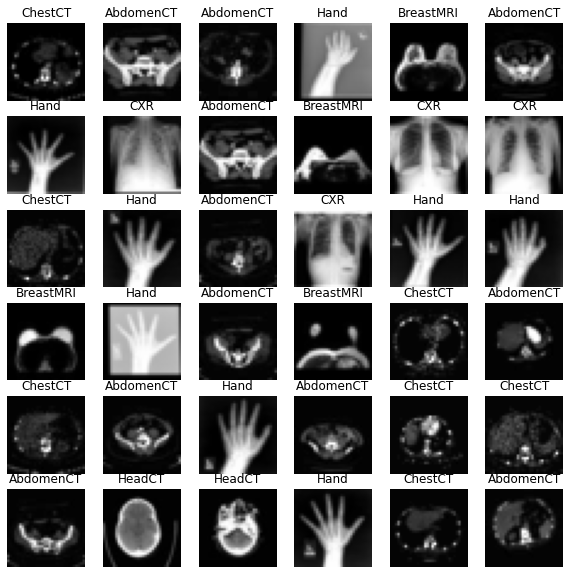

In [ ]:
#Display the dataset images
def eda(N_IMAGES, classes):

    #Get images and corresponding labels
    images, labels = zip(*[(image, label) for image, label in
                       [trainset[i] for i in np.random.randint(0, len(trainset), N_IMAGES)]])
    #Total images
    n_images = len(images)

    #Number of rows and columns in the grid
    rows, cols = int(np.sqrt(n_images)), int(np.sqrt(n_images))

    #Create empty figure
    fig = plt.figure(figsize=(10, 10))

    #Total grid points
    total_imgs = rows*cols

    #Iterate over each grid element
    for i in range(total_imgs):

        #Create a subplot
        ax = fig.add_subplot(rows, cols, i+1)
        #Get an image
        image = images[i]
        #Calculate min max and clamp the image
        image_min, image_max = image.min(), image.max()
        image.clamp_(min=image_min, max=image_max)
        image.add_(-image_min).div_(image_max - image_min + 1e-5)
        #Plot and label the image
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

#Total images to plot
N_IMAGES = 36
#Class labels
classes = testset.classes

#Call the plot function
eda(N_IMAGES, classes)

In [ ]:
#Images count
count_train = 0
for root_dir, cur_dir, files in os.walk(r'/content/Medical/Medical_train/'):
    count_train += len(files)
print('Train images count:', count_train)

count_test = 0
for root_dir, cur_dir, files in os.walk(r'/content/Medical/Medical_test/'):
    count_test += len(files)
print('Test images count:', count_test)

print('Total images count: ', count_train+count_test)

Train images count: 58954
Test images count: 12000
Total images count:  70954


#Design Model

In [ ]:
#Input shape
input_shape = 32*32*3
#Output shape
output_classes = 6
#Hidden layers sizes
l1, l2, l3, l4 = 256, 128, 64, 32

#Create the custom model
class classifier(nn.Module):
  def __init__(self):
    super().__init__()
    #Define layers and shapes 
    self.lin1 = nn.Linear(input_shape, l1)
    self.lin2 = nn.Linear(l1, l2)
    self.lin3 = nn.Linear(l2, l3)
    self.lin4 = nn.Linear(l3, l4)
    self.lin5 = nn.Linear(l4, output_classes)

  #Model forward pass  
  def forward(self, x):
    #Stacking layers
    x = x.view(x.shape[0], -1)
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = F.relu(self.lin3(x))
    x = F.relu(self.lin4(x))
    x = F.log_softmax(self.lin5(x), dim = 1)   
    return x

#Evaluation Metrics

In [ ]:
def model_predict(model, loader):
    #Set model in evaluation mode
    model.eval()
    #Variable to store labels and predictions
    labels = []
    predictions = []
    #Set torch in no gradient mode
    with th.no_grad():
        #Iterate over test data loader
        for (img, lab) in loader:
            #Model prediction
            y_pred = model(img)
            #Store label and prediction
            labels.append(lab)
            predictions.append(y_pred)
            
    #Post process the labels and predictions
    labels = th.cat(labels, dim=0)
    predictions = th.cat(predictions, dim=0)
    predictions = np.argmax(predictions, axis=1)

    return labels, predictions

#This function is used for plotting the confusion matrix and classification report
def eval_metrics(ytrue, ypred):
    #Classification report
    print(metrics.classification_report(ytrue, ypred, target_names=classes))
    #Confusion matrix
    matrix = metrics.confusion_matrix(ytrue, ypred)
    #Plot the matrix
    plt.figure(figsize=(8, 8),dpi=100)
    sns.heatmap(matrix,
                cmap='Blues',
                linecolor='white',
                linewidths=1,
                xticklabels=list(classes),
                yticklabels=list(classes),
                annot=True,
                fmt='d')
    #Label the plot
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')
    plt.show()

#Model Central Training

In [ ]:
#Model traning step
def train(model, loader, optimizer, criterion):
  #Variable to store the loss
  cum=0
  #Iterate over training batches
  for idx, (data,lab) in enumerate(loader):
    #Reset optimizer
    optimizer.zero_grad()
    #Calculate model output
    out = model(data)
    #Calculate loss
    loss = criterion(out,lab)
    #Accumulate the loss
    cum+=loss
    #Calculate gradients
    loss.backward()
    #Update weights
    optimizer.step()
  #Print the loss for the epoch
  print(cum)
  return cum

#Train the model
def train_model(epochs=5):
  #Call model class
  model = classifier()
  #Model optimizer
  optimizer = optim.SGD(model.parameters(), 0.001)
  #Model loss function
  criterion = nn.NLLLoss()
  #Variable to store the loss 
  losses = []
  #Loop over each iteration
  for epoch in range(1, epochs):
    #Print current epoch number
    print("Epoch: ", epoch)
    #Perform training step
    epoch_loss = train(model, train_loader, optimizer, criterion)
    losses.append(float(epoch_loss))
  return model, losses

#Number of epochs to train the model
epochs = 50

#Model training
model_1, loss_1 = train_model(epochs+1)

Epoch:  1
tensor(1643.5087, grad_fn=<AddBackward0>)
Epoch:  2
tensor(1574.1548, grad_fn=<AddBackward0>)
Epoch:  3
tensor(1362.1869, grad_fn=<AddBackward0>)
Epoch:  4
tensor(1146.8179, grad_fn=<AddBackward0>)
Epoch:  5
tensor(947.7918, grad_fn=<AddBackward0>)
Epoch:  6
tensor(784.2681, grad_fn=<AddBackward0>)
Epoch:  7
tensor(603.3434, grad_fn=<AddBackward0>)
Epoch:  8
tensor(468.6310, grad_fn=<AddBackward0>)
Epoch:  9
tensor(400.4453, grad_fn=<AddBackward0>)
Epoch:  10
tensor(345.0622, grad_fn=<AddBackward0>)
Epoch:  11
tensor(293.9683, grad_fn=<AddBackward0>)
Epoch:  12
tensor(248.2601, grad_fn=<AddBackward0>)
Epoch:  13
tensor(208.4426, grad_fn=<AddBackward0>)
Epoch:  14
tensor(174.9885, grad_fn=<AddBackward0>)
Epoch:  15
tensor(148.0147, grad_fn=<AddBackward0>)
Epoch:  16
tensor(126.8439, grad_fn=<AddBackward0>)
Epoch:  17
tensor(110.4795, grad_fn=<AddBackward0>)
Epoch:  18
tensor(97.7006, grad_fn=<AddBackward0>)
Epoch:  19
tensor(87.8101, grad_fn=<AddBackward0>)
Epoch:  20
tensor(7

##Model Loss

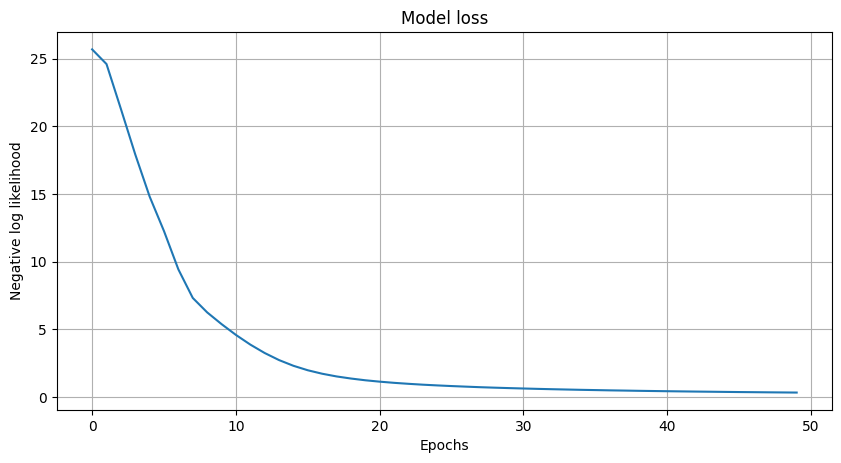

In [ ]:
#Plot the loss
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),np.asarray(loss_1)/64);
#Label the plot
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Model loss")
plt.grid()

##Confusion matrix and classification report

              precision    recall  f1-score   support

   AbdomenCT       0.99      1.00      1.00      2000
   BreastMRI       1.00      1.00      1.00      2000
         CXR       1.00      0.99      1.00      2000
     ChestCT       1.00      1.00      1.00      2000
        Hand       0.99      0.98      0.99      2000
      HeadCT       0.99      1.00      0.99      2000

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



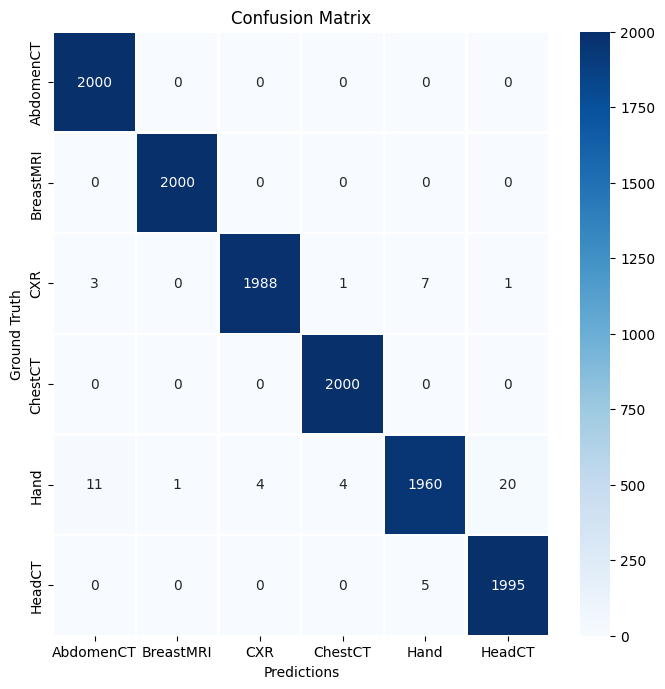

In [ ]:
#Model prediction
labels, predictions_1 = model_predict(model_1, test_loader)

#Plot confusion matrix and classification report
eval_metrics(labels, predictions_1)

In [ ]:
print("Accuracy of the central model is: ",metrics.accuracy_score(labels, predictions_1))

Accuracy of the central model is:  0.99525


#Federated Learning

In [ ]:
#Link pytorch to pysift
hook = sy.TorchHook(th)

#Create 10 virtual hospitals
def create_hospitals():
  hospitals = []
  hosp_1 = sy.VirtualWorker(hook, id = "Hospital-1")
  hospitals.append(hosp_1)
  hosp_2 = sy.VirtualWorker(hook, id = "Hospital-2")
  hospitals.append(hosp_2)
  hosp_3 = sy.VirtualWorker(hook, id = "Hospital-3")
  hospitals.append(hosp_3)
  hosp_4 = sy.VirtualWorker(hook, id = "Hospital-4")
  hospitals.append(hosp_4)
  hosp_5 = sy.VirtualWorker(hook, id = "Hospital-5")
  hospitals.append(hosp_5)
  hosp_6 = sy.VirtualWorker(hook, id = "Hospital-6")
  hospitals.append(hosp_6)
  hosp_7 = sy.VirtualWorker(hook, id = "Hospital-7")
  hospitals.append(hosp_7)
  hosp_8 = sy.VirtualWorker(hook, id = "Hospital-8")
  hospitals.append(hosp_8)
  hosp_9 = sy.VirtualWorker(hook, id = "Hospital-9")
  hospitals.append(hosp_9)
  hosp_10 = sy.VirtualWorker(hook, id = "Hospital-10")
  hospitals.append(hosp_10)
  return hospitals

#Function to clear tensors in hospitals
def clear_hospitals(hospitals):
  for hospital in hospitals:
    hospital.clear_objects()

#Create federated dataset
def federated_dataloader(hospitals, loader):
  loader.data = loader.targets = True
  federated_loader = sy.FederatedDataLoader(
      loader.federate(hospitals), 
      batch_size=64, shuffle=True)
  return federated_loader

#Obtain central model
def update_central_model(model):
  return model.get()



#Train the model using federated learning
def federated_training(hospitals, loader, epoch = 5):
  #Send model to 1st virtual hospital
  virtual_model = classifier().send(hospitals[0])

  #Model optimizer
  optimizer = optim.SGD(virtual_model.parameters(), 0.001)

  #Model loss function
  criterion = nn.NLLLoss()

  #Variable to store losses for each hospital
  losses = []

  #Iterate over number of epochs
  for n in range(epoch):
    
    #indexing integers
    i, j = 0, 0
    #mini batch per hospital
    n_mbatch = 0
    #hospital variable
    dbLoc = None
    #store loss for each hospital
    cum_loss = 0
    #Iterate over batches
    for batch_idx, (imgs, labels) in enumerate(loader):
      
      #lock to first hospital
      if i == 0:
        i = 2
        dbLoc = imgs.location
        
      # change the lock to other hospitals
      if dbLoc is not imgs.location:
        # print the loss to screen
        print("The total loss for {0} for epoch {2} is {1}".format(hospitals[j].id, cum_loss / n_mbatch, n+1))

        #Store loss value
        losses.append([hospitals[j].id, cum_loss / n_mbatch])
        dbLoc = imgs.location
        j += 1
        
        #Shift model to next hospital
        virtual_model.move(dbLoc)
        
        #Reset loss and batch value
        cum_loss = 0
        n_mbatch = 0

      # Reset optimizer values
      optimizer.zero_grad()
      #Calculate model output
      output = virtual_model.forward(imgs)
      #Calculate loss
      loss = criterion(output, labels)
      #Calculate gradient
      loss.backward()
      #Update weights
      optimizer.step()
      #Accumulate loss
      cum_loss +=  loss.get().item()
      #Update batch
      n_mbatch += 1
    
    #Print loss value
    print("The total loss for {0} is {1}".format(hospitals[j].id, cum_loss / n_mbatch))
    #Store loss value
    losses.append([hospitals[j].id, cum_loss / n_mbatch])
    
    #Move model to first worker
    if (n < (epoch - 1)):
      virtual_model.move(hospitals[0])
  return virtual_model, losses

##Create Federated Data

In [ ]:
#Create virtual hospitals
hospitals = create_hospitals()

#Clear tensor values
clear_hospitals(hospitals)

#Create federated dataset
federated_loader = federated_dataloader(hospitals, trainset)

##Model Federated Training

In [ ]:
#Model training
virtual_model, loss_2 = federated_training(hospitals, federated_loader, epoch = epochs)

#Get model centralized
model_2 = update_central_model(virtual_model)

The total loss for Hospital-1 for epoch 1 is 1.7953254035724107
The total loss for Hospital-2 for epoch 1 is 1.7469720558453632
The total loss for Hospital-3 for epoch 1 is 1.7332789513372606
The total loss for Hospital-4 for epoch 1 is 1.7058724985327771
The total loss for Hospital-5 for epoch 1 is 1.6495665106722104
The total loss for Hospital-6 for epoch 1 is 1.7203140515153126
The total loss for Hospital-7 for epoch 1 is 1.7866881009071105
The total loss for Hospital-8 for epoch 1 is 1.8037380492815407
The total loss for Hospital-9 for epoch 1 is 1.8318953296189666
The total loss for Hospital-10 is 1.6469533802360616
The total loss for Hospital-1 for epoch 2 is 1.780202050362864
The total loss for Hospital-2 for epoch 2 is 1.7081180234109201
The total loss for Hospital-3 for epoch 2 is 1.3006014785458964
The total loss for Hospital-4 for epoch 2 is 1.5110768797577068
The total loss for Hospital-5 for epoch 2 is 1.6487762376826296
The total loss for Hospital-6 for epoch 2 is 1.70967

##Federated Loss

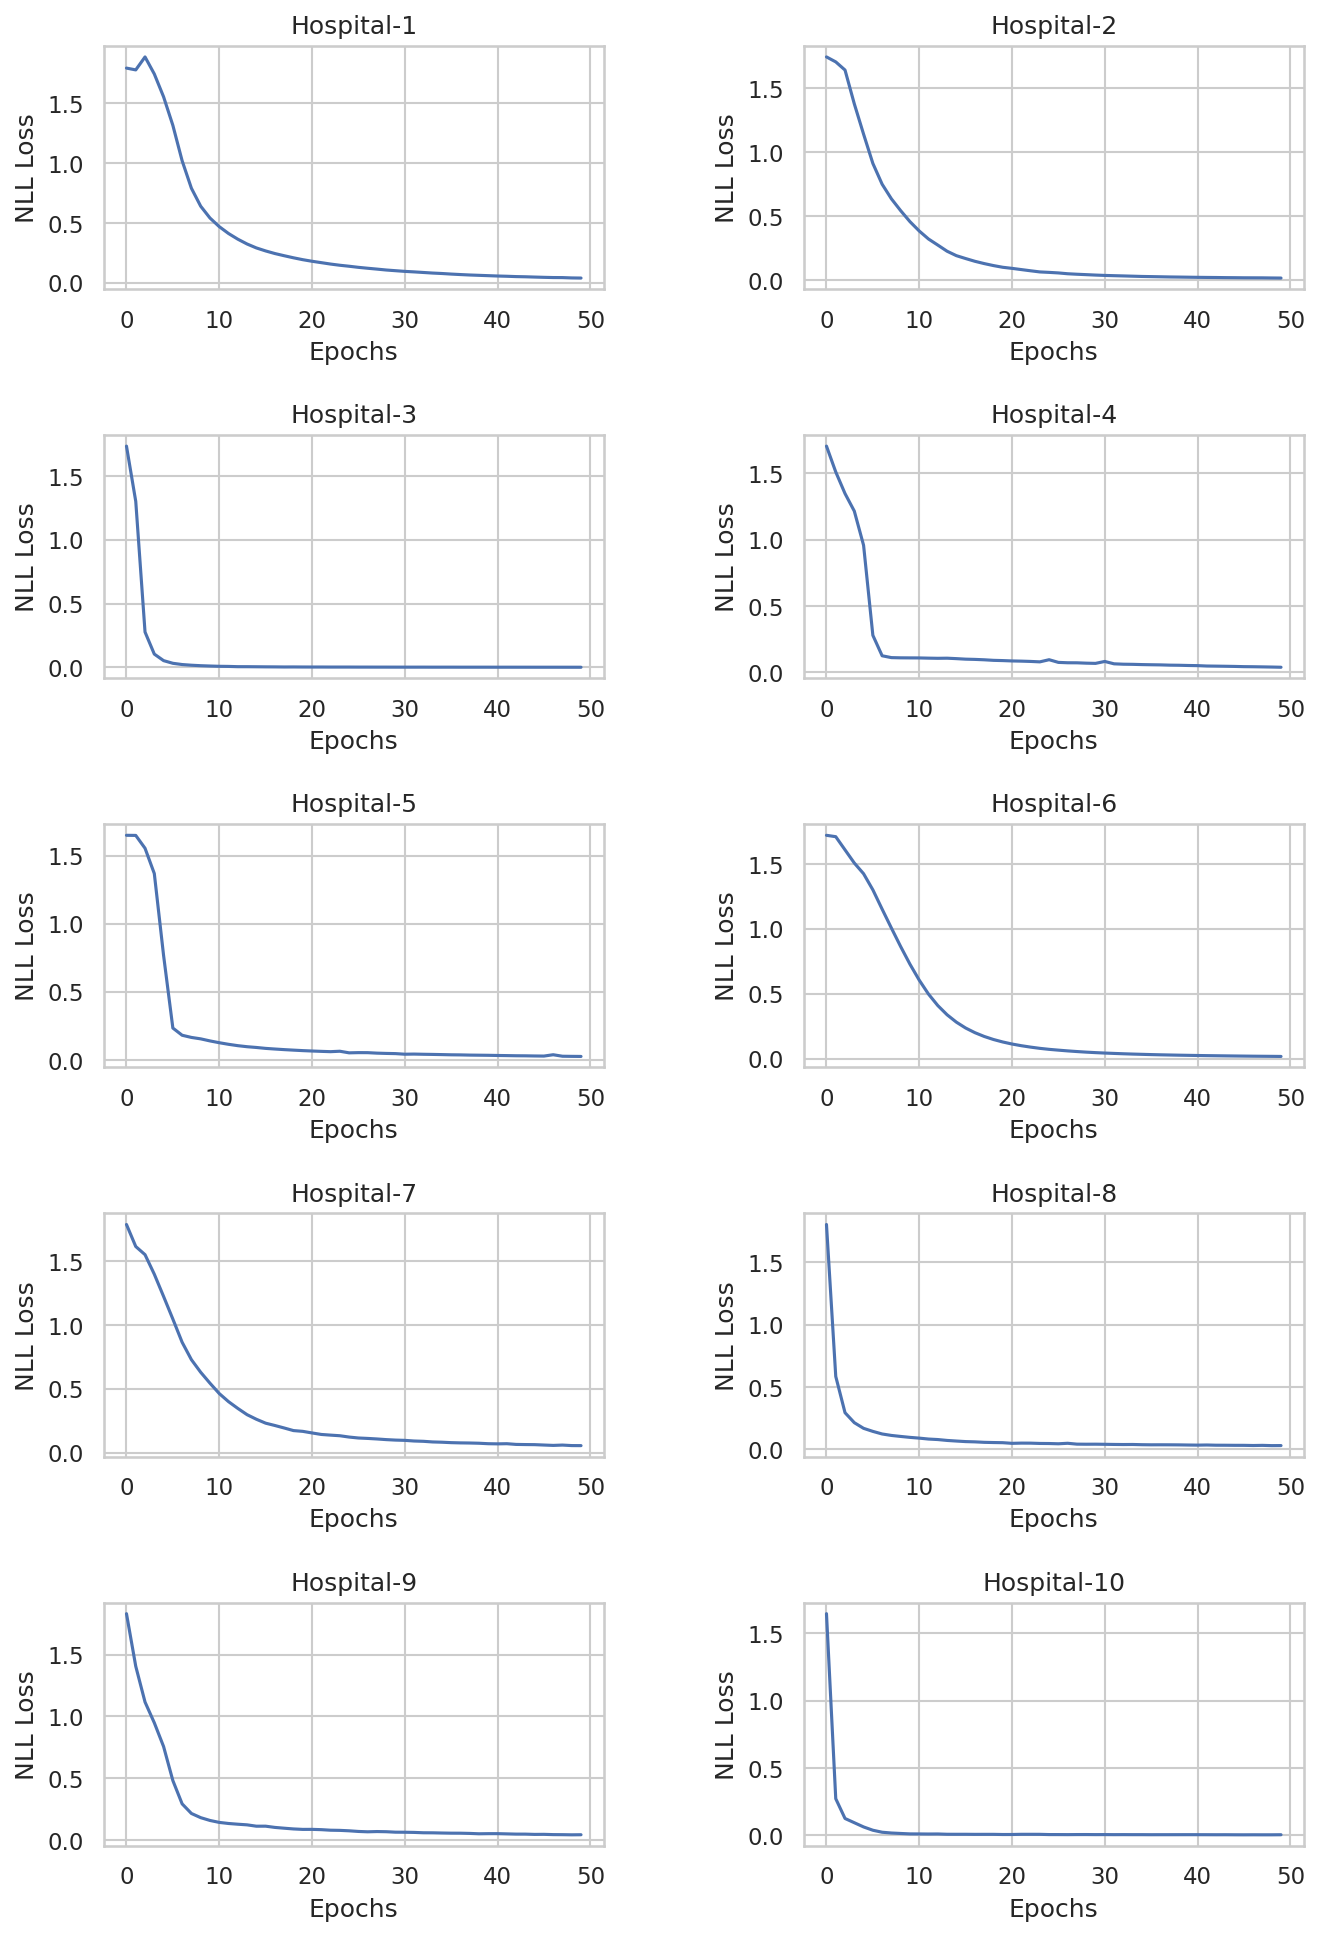

In [ ]:
#Hospital labels
lab_hosp = ['Hospital-1',
            'Hospital-2',
            'Hospital-3',
            'Hospital-4',
            'Hospital-5',
            'Hospital-6',
            'Hospital-7',
            'Hospital-8',
            'Hospital-9',
            'Hospital-10']
            
#Total labels
lab_total = lab_hosp.append("Central")

#Total hospitals
total_hosp=len(hospitals)

#Sort federated losses
loss2_sort=[]
for i in range(10):
  loss2_sort.append(loss_2[i::10])

sns.set_theme(style='whitegrid')
fig = plt.figure(figsize=(10, 15), dpi=150)
#Iterate over each hospital
for i in range(total_hosp):
  current_hosp=[]
  #Fetch loss for each hospital
  for k in range(epochs):
    current_hosp.append(loss2_sort[i][k][1])
  
  #Plot the loss for current hospital
  fig.add_subplot(5,2, i+1)
  plt.plot(range(epochs), current_hosp)
  plt.xlabel("Epochs")
  plt.ylabel("NLL Loss")
  plt.title(lab_hosp[i])
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)

##Confusion matrix and Classification report

              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      2000
   BreastMRI       1.00      0.42      0.59      2000
         CXR       1.00      0.96      0.98      2000
     ChestCT       1.00      1.00      1.00      2000
        Hand       0.96      0.96      0.96      2000
      HeadCT       0.62      1.00      0.77      2000

    accuracy                           0.89     12000
   macro avg       0.93      0.89      0.88     12000
weighted avg       0.93      0.89      0.88     12000



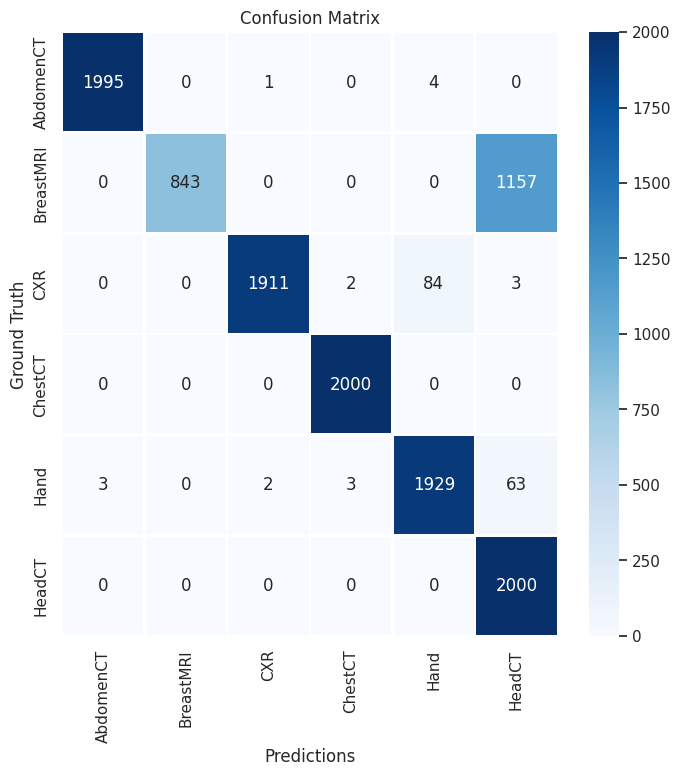

In [ ]:
#Model predictions
labels, predictions_2 = model_predict(model_2, test_loader)
#Plot conf matrix and report
eval_metrics(labels, predictions_2)

In [ ]:
print("Accuracy of the federated model is: ",metrics.accuracy_score(labels, predictions_2))

Accuracy of the federated model is:  0.8898333333333334


#Comparisons

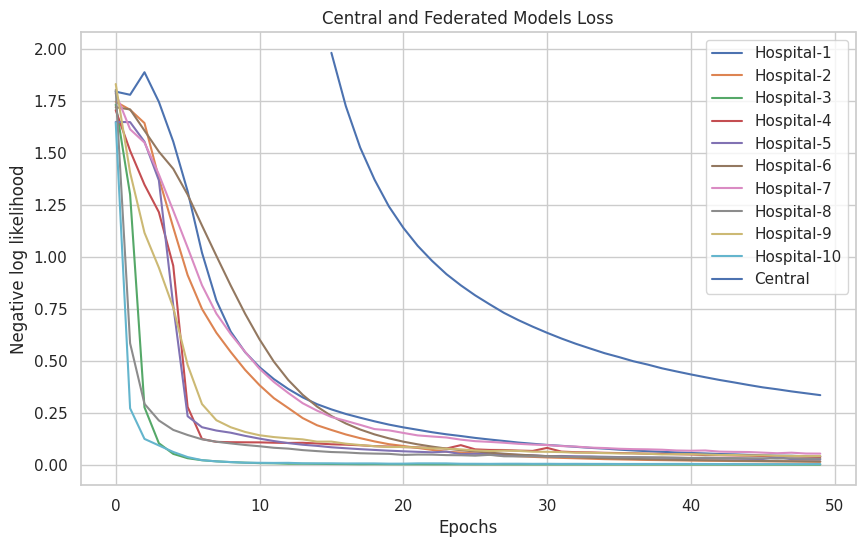

In [ ]:
#Plot federated losses
plt.figure(figsize=(10,6),dpi=100)
for i in range(total_hosp):
  cur_hosp=[]
  for k in range(epochs):
    cur_hosp.append(loss2_sort[i][k][1])
  plt.plot(range(epochs),cur_hosp)

#Plot central loss
plt.plot(range(epochs)[15:],np.asarray(loss_1)[15:]/64)
#Label the plots
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Central and Federated Models Loss")
plt.legend(lab_hosp)

(-0.4, 1.5)

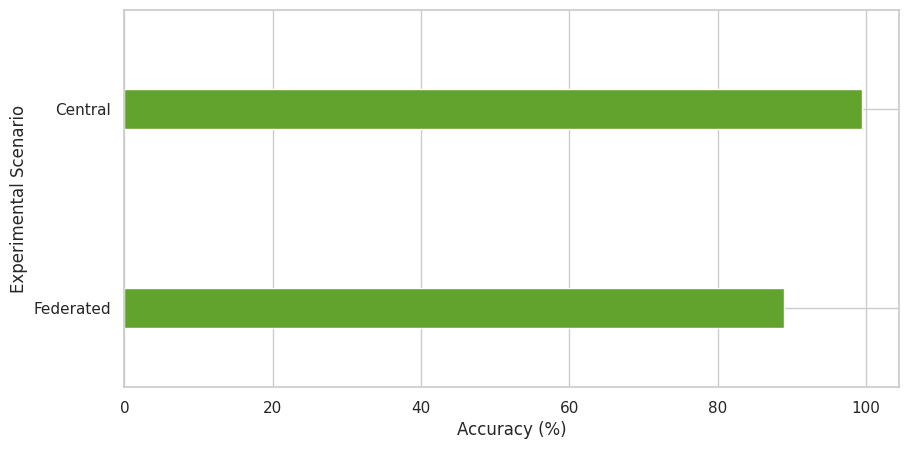

In [ ]:
x = np.arange(2)
y1 = [88.9,99.5]  
width = 0.2

sns.set_theme(style='whitegrid', palette='PiYG_r')
plt.figure(figsize=(10,5), dpi=100)
  
# plot data in grouped manner of bar type
plt.barh(x, y1, width)
plt.xlabel("Accuracy (%)")
plt.ylabel("Experimental Scenario")
plt.yticks(x, ['Federated','Central'])
plt.ylim([-0.4, 1.5])